#### Importy

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

import numpy as np

import matplotlib.pyplot as plt

from typing import Tuple, List, Callable, Optional

#### Funkcje pomocnicze

In [2]:
def stworz_zbior_danych(f: Callable, n: int, x_min: float = 0, x_max: float = 1, szum: Optional[float] = None) -> Tuple[Tensor]:
    r"""
    Funkcja generująca zbiór danych na podstawie funkcji f(x) w przedziale [x_min, x_max] o długości n.
    """
    x = torch.linspace(start=x_min, end=x_max, steps=n)
    if szum is None:
        y = f(x)
    else:
        y = f(x) + torch.randn(size=n) * szum
    return x, y


def narysuj_wykres_funkcji(funkcja: Callable, x_min: float=0, x_max: float=1, narysuj_punkty: bool=False, label: str='', szum: Optional[float]=None, grubosc_linii: float=1) -> None:
    r"""
    Funkcja rysująca wykres funkcji f(x) w przedziale [x_min, x_max].
    """
    x, y = stworz_zbior_danych(f=funkcja, n=100, x_min=x_min, x_max=x_max, szum=szum)
    
    if x.requires_grad:
        x = x.detach()
    if y.requires_grad:
        y = y.detach()
    
    plt.plot(x, y, label=label, linewidth=grubosc_linii)
    if narysuj_punkty:
        plt.scatter(x, y, color='black')
    plt.legend()
    plt.grid()

### Spis treści
1. Problem przybliżania funkcji

### **Problem przybliżania funkcji**

Ucząc sieci neuronowe często będziemy mieli do czynienia z tzw. uczeniem nadzorowanym (**supervised learning**), który wiaże się ściśle z problemem przybliżania fukcji (**function approximation**). W praktyce otrzymamy pewne dane wejściowe (**input data**) oraz oczekiwane dane wyjściowe (**output data**) modelu uczenia maszynowego.

##### **Sformułowanie problemu przybliżania funkcji**
Wprowadźmy dla porządku elementy notacji metematycznej, która posłuży nam do definiowania problemów w tym notatniku.

Przez $x$ oznaczajmy zmienną, której wartości znamy, a przez $y$ zmienną, której relację z $x$ chcemy przybliżyć korzystając z sieci neuronowej. Niech $f_{prawda}(x)=y$ opisuje prawdziwe (i z reguły nieznane nam) przekształcenie opisujące relację między $x$ i $y$. Naszym celem jest znalezienie funkcji $f_{aproksymacja}(x;\theta)=\hat{y}$, która przybliża $f_{prawda}(x)$ i korzysta w obliczeniach z parametrów $\theta$. Chcemy zatam, aby zachodziło $f_{aproksymacja}(x;\theta)=\hat{y} \approx f_{prawda}$.

Mamy więc daną funkcję opisującą prawdziwą relację $x$ i $y$
$$f_{prawada}(x):X\ni x\rightarrow y\in Y$$
gdzie $X$ i $Y$ stanowią zbiory wartości odpowiednio $x$ i $y$, oraz model uczenia maszynowego o pewnych parametrach $\theta$ dany przez
$$f_{aproksymacja}(x;\theta):X\times\Theta\ni(x,\theta)\rightarrow y\in Y$$
gdzie $\theta$ oznacza parametry modelu. Dla rozróżnienia będziemy oznaczać wyjście z sieci neuronowej przez $\hat{y}$.

Warto podkreślić, że w praktyce nie znamy funkcji $f_{prawda}(x)$, ale mamy dostęp do danych treningowych, które są próbkami z $f_{prawda}(x)$. Naszym celem jest znalezienie takich parametrów $\theta$, które minimalizują błąd aproksymacji między $f_{prawda}(x)$ i $f_{aproksymacja}(x;\theta)$. Dodatkowo $f_{aproksymacja}$ jest ustaloną funkcją danych wejściowych i parametrów modelu, a nieznanymi są parametry $\theta$. Te parametry modyfikują zachowanie $f_{aproksymacja}$ dla ustalonych wartości $x$. To właśnie poszukiwanie właściwych parametrów $\theta$ będzie stanowić zasadnicze zadanie trenowania sieci neuronowej.

### **Przybliżanie funkcji liniowej siecią neuronową**
Zacznijmy od prostego przypadku $f_{prawda}(x)=a\cdot x + b$ gdzie $a, b\in\mathbb{R}$ stanowią pewne parametry.

Poniżej znajduje się definicja klasy, która pozwala tworzyć obiekty odpowiadające liniowej postaci $f_{prawda}$ dla $x, y\in\mathbb{R}$.

In [3]:
class FPrawda():
    def __init__(self, a: float, b: float):
        self.a: float = a
        self.b: float = b

    def __call__(self, x: float) -> float:
        return self.a * x + self.b

Zwizualizujmy teraz funkcję $f_{prawda}$.

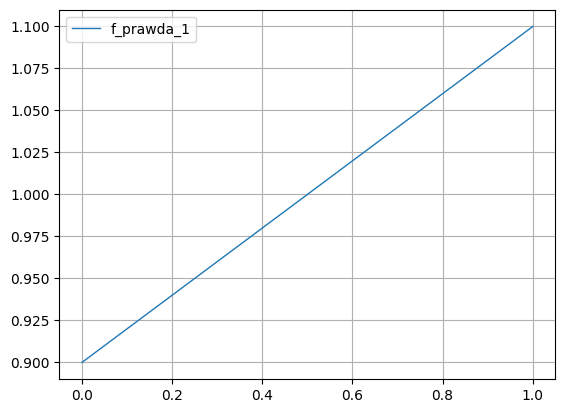

In [4]:
f_prawda_1 = FPrawda(a = 0.2, b = 0.9)
narysuj_wykres_funkcji(f_prawda_1, label='f_prawda_1')

#### `torch` - 1
Zanim zaczniemy definiować modele, które będą aproksymować $f_{prawda}$ określmy najistotniejsze w tym momencie dla nas elementy pakietu `torch`:
- `torch.nn.Module` - Modele będą dziedziczyły od tej klasy. Obsługuje ona wiele funkcjonalności koniecznych do trenowania modelu.
- `torch.nn` - Moduł dostarczający wiele funkcjonalności w postaci klasowej.
- `torch.nn.functional` - Moduł dostarczający wiele funkcjonalności w postaci funkcyjnej.
- `torch.nn.init` - Moduł obsługujący inicjalizację parametrów modelu.

Ogólna struktura definicji klasy modelu opartego o pakiet `torch` wygląda zazwyczaj następująco
```python
class NaszModel(nn.Module):
    def __init__(self):                     # __init__ jest metodą wywoływaną podczas inicjalizacji nowego obiektu klasy. self oznacza obiekt klasy, który podawany jest jako pierwszy argument konstrukutar przy inicjalizacji.
        super(NaszModel, self).__init__()   # Wywołanie metody __init__ klasy rodzica nn.Module
        ...                                 # Definicja architektury modelu oraz inicjalizacja parametrów

    def forward(self,                       # forward to typowa obowiązkowa metody obiektu podklacy nn.Module określająca zasadnicze obliczenia modelu
                x: torch.Tensor             # Zaznaczamy, że model przyjmuje obiekt typu torch.Tensor
                ) -> torch.Tensor:          # Zaznaczamy, że model zwraca obiekt typu torch.Tensor
        ...                                 # Określamy zasadniczą część obliczeń do wykonania
        return output                       # Zwracamy wynik obliczeń
```

Zdefiniujmy teraz pierwszy model z jednym parametrem postaci $f_{aproksymacja}(x;\theta)=\theta$ gdzie $\theta\in\mathbb{R}$. Nasz model będzie zwracał stałą wartość dla dowolnego $x$.

In [5]:
class FAproksymacja1(nn.Module):
    def __init__(self):
        super(FAproksymacja1, self).__init__()      # Wywołujemy metodę __init__ nn.Module
        self.theta = nn.Parameter(torch.empty(1))   # Definiujemy parametr modelu. W gruncie rzeczy jest to float, ale aby móc go optymalizować, musi być to Tensor. Używamy specjalnej klasy nn.Parameter do tego celu.
        nn.init.uniform_(self.theta)                # Inicjalizujemy losowo parametr modelu
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.theta * torch.ones_like(input=x)  # Wykonujemy obliczenie zgodnie z definicją postaci f_aproksymacja
        return output                                   # Zwracamy wynik obliczeń

Zdefiniujmy dwie instancje naszej klasy `FAproksymacja1`

In [6]:
f_aproksymacja_1_0 = FAproksymacja1()
f_aproksymacja_1_1 = FAproksymacja1()

Zdefiniujmy jesze bardziej ekspresywny model (mogący reprezentować szerszy zakres funkcji) z dwoma parametrami postaci $f_{aproksymacja}(x;\theta)=\theta_0\cdot x + \theta_1$ gdzie $\theta=(\theta_0, \theta_1)\in\mathbb{R^2}$.

In [7]:
class FAproksymacja2(nn.Module):
    def __init__(self):
        super(FAproksymacja2, self).__init__()      
        self.theta = nn.Parameter(torch.empty(2))   
        nn.init.uniform_(self.theta)                
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.theta[0] * x + self.theta[1]  # Wykonujemy obliczenie zgodnie z definicją postaci f_aproksymacja
        return output                               

In [8]:
f_aproksymacja_2_0 = FAproksymacja2()
f_aproksymacja_2_1 = FAproksymacja2()

Zwizualizujmy wyniki obliczeń dla naszych modeli i porównajmy je z prawdziwą funkcją.

In [9]:
x, y = stworz_zbior_danych(f=f_aproksymacja_1_0, n=100, x_min=0, x_max=1, szum=None)
x.shape, y.shape

(torch.Size([100]), torch.Size([100]))

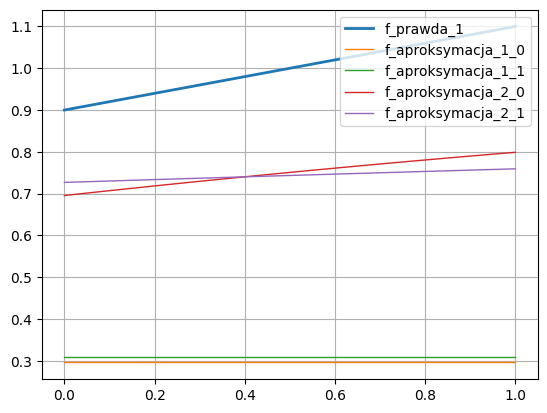

In [10]:
narysuj_wykres_funkcji(f_prawda_1, label='f_prawda_1', grubosc_linii=2)
narysuj_wykres_funkcji(f_aproksymacja_1_0, label='f_aproksymacja_1_0')
narysuj_wykres_funkcji(f_aproksymacja_1_1, label='f_aproksymacja_1_1')
narysuj_wykres_funkcji(f_aproksymacja_2_0, label='f_aproksymacja_2_0')
narysuj_wykres_funkcji(f_aproksymacja_2_1, label='f_aproksymacja_2_1')

Jak widać z powodu losowej inicjalizacji otrzymujemy inne wykresy dla modeli tego samego typu. Jednocześnie nie dziwi, że losowo zainicjalizowane modele nie pozwalają ująć prawdziwej relacji $x$ i $y$. Zajmijmy się w takim razie kwestią treningu/uczeni modeli co pozwoli nam znaleźć odpowiednie parametry modeli.

### 3 **Optymalizacja**

Aby znaleźć odpowiednie $f_{aproksymacja}$ musimy najpierw zdefiniować problem optymalizacyjny. Rozwiązując ten problem możemy doprowadzić do znalezienia odpowiednich parametrów $\theta$.

Wprowadźmy następującą notację. Niech $\mathbf{x}=(x_0, x_{n-1})$ określa próbki zmiennej $X$, $\mathbf{y}=(y_0, ..., y_{n-1})$ próbki zmiennej $Y$ oraz $\mathbb{\hat{y}}=(\hat{y}_0, ..., \hat{y}_{n-1})$ wyniki zwracane przez model gdzie $n$ to liczba próbek oraz $i$ określa indeksy tych próbek.
 
Określmy tzw. funkcję straty (**loss function**) jako pewną miarę odległości funkcji $f_{aproksymacji}$ i $f_{prawda}$ zależną od danych $(\mathbf{x}, \mathbf{y})$:
\begin{equation}
J(\theta;\mathbf{x}, \mathbf{y}) = \sum_{i=0}^{n-1} d(y_i, \hat{y}_i) = \sum_{i=0}^{n-1} d(y_i, f_{aproksymacja}(x_i;\theta))\nonumber
\end{equation}
gdzie $d$ określa pewną miarę odległości. Zmieniając definicję $d$ można określić wiele sensownych funkcji straty. Nasza funkcja straty mierzy zatem podobieństwo między prawdziwą funkcją a modelem, który ją aproksymuje.

Zaobserwujmy, że podczas obliczania $\hat{y}=f_{aproksymacja}(x;\theta)$ tzw. przechodzenia wprzód (**forward pass**) traktujemy parametry $\theta$ jako stałe. Z kolei podczas procesu optymalizacyjnego powiązanego z obliczeniem wartości funkcji straty $J(\theta;\mathbf{x}, \mathbf{y})$ i tzw. przejścia wstecz (**backward pass**) traktujemy próbki $\mathbf{x}$ i oczekiwane wartości predykcji (**targets**) $\mathbf{y}$ jako ustalone. Później zastanowimy się głębiej nad znaczeniem sformułowania fukcji straty jako średniej arytmetycznej błędów określonych dla poszczególnych próbek (`TODO`: omówić w niezależności próbek i maximum likelihood).

#### `torch` - 2
Wprowadźmy kolejne przydatne elementy pakietu `torch` przy oznaczeniu `torch.nn.functional` przez `F`:
- `F.mse_loss`, `F.l1_loss`, `F.smooth_l1_loss`, `F.huber_loss` - Wykorzystamy zdefiniowane funkcje straty. Wymienione funkcje straty mają swoje klasowe odpowiedniki w module `torch.nn` odpowiednio `MSELoss`, `L1Loss`, `SmoothL1Loss`, `HuberLoss`.
- `torch.optim.SGD` - Będziemy wykorzystować optimizer czyli algorytmy służące do optymalizacji parametrów.

Zadania pozwolą się z nimi lepiej zaznajomić. (`TODO`: omówić implementację optymalizatorów z wizualizacjami jak dla ustalonej funkcji i startu w jednym pkt wyglądają trajektorie updateów). Ważne, aby wiedzieć, że pozwalają one wyznaczyć wartości parametrów modelu, które mają minimalizować zadaną funkcję straty.

Przytoczmy definijce funkcji straty MSE (Mean Squared Error): 
\begin{equation}
J(\theta;\mathbf{x}, \mathbf{y}) = MSE(\mathbf{\hat{y}}, \mathbb{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2} \nonumber
\end{equation}
gdzie $n$ oznacza liczbę przykładów uczących, a indeksy $i$ określają poszczególne próbki w zbiorze danych uczących.

Przygotujmy najpier pomocnicze funkcje, które pozwolą nam zwizualizować funkcję straty w zależności od parametrów modeli. Warto zwrócić uwagę, żę będziemy potrzebowali zbioru danych do obliczenia funkcji straty. W konsekwencji zawartość zbioru danych ściśle wiąże się z wykresem funkcji straty.

In [11]:
f_straty_1 = F.mse_loss
f_straty_2 = F.l1_loss
f_straty_3 = F.smooth_l1_loss
f_straty_4 = F.huber_loss
x, y = stworz_zbior_danych(f=f_prawda_1, n=100, x_min=-5, x_max=5, szum=None)

In [12]:
def zwizualizuj_fstraty_dla_jednego_parametru(f_straty: Callable, x: Tensor, y: Tensor, model: nn.Module, theta_min: float, theta_max: float, label: str) -> None:
    thety = torch.linspace(start=theta_min, end=theta_max, steps=100)
    straty1d = torch.empty_like(input=thety)
    for i, theta in enumerate(thety):
        model.theta.data.fill_(theta)
        y_pred = model(x)
        straty1d[i] = f_straty(y_pred, y).detach()
    plt.plot(thety, straty1d, label=label)
    plt.xlabel('Parametr modelu')
    plt.ylabel('Wartość funkcji straty')
    plt.legend()
    plt.grid()

Zwizualizujmy najpierw nasza wyżej zdefiniowaną funkcję straty MSE.

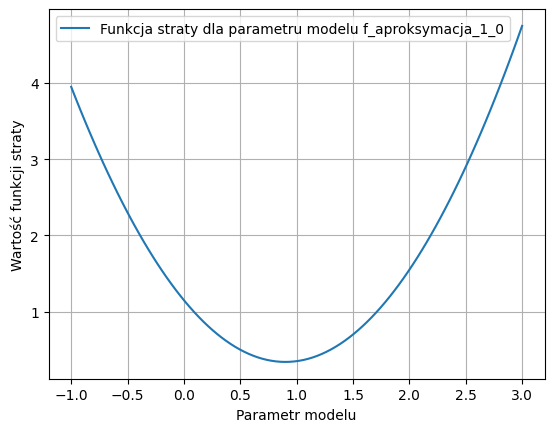

In [13]:
zwizualizuj_fstraty_dla_jednego_parametru(f_straty_1, x, y, f_aproksymacja_1_0, theta_min=-1, theta_max=3, label='Funkcja straty dla parametru modelu f_aproksymacja_1_0')

Zestwmy MSE z innymi funkcjami straty (`TODO` ćwiczenie - sprawdź nn.functional i nn w poszukiwaniu zaimplementowanych funkcji straty i otwórz definicję. zapisz własną wymyśloną funkcje straty i porównaj ją na wykresie z innymi)

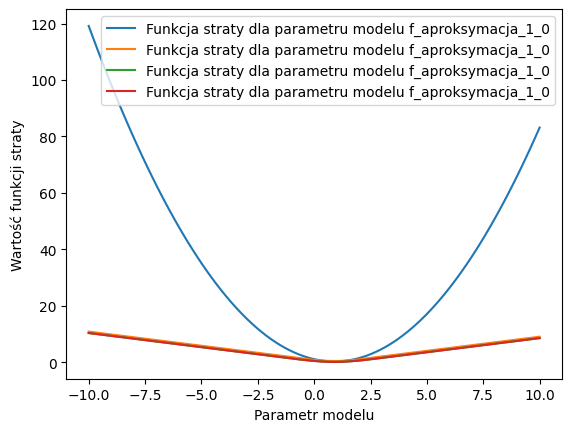

In [14]:
zwizualizuj_fstraty_dla_jednego_parametru(f_straty_1, x, y, f_aproksymacja_1_0, theta_min=-10, theta_max=10, label='Funkcja straty dla parametru modelu f_aproksymacja_1_0')
zwizualizuj_fstraty_dla_jednego_parametru(f_straty_2, x, y, f_aproksymacja_1_0, theta_min=-10, theta_max=10, label='Funkcja straty dla parametru modelu f_aproksymacja_1_0')
zwizualizuj_fstraty_dla_jednego_parametru(f_straty_3, x, y, f_aproksymacja_1_0, theta_min=-10, theta_max=10, label='Funkcja straty dla parametru modelu f_aproksymacja_1_0')
zwizualizuj_fstraty_dla_jednego_parametru(f_straty_4, x, y, f_aproksymacja_1_0, theta_min=-10, theta_max=10, label='Funkcja straty dla parametru modelu f_aproksymacja_1_0')

Jak daje się zauważyć MSE w porówaniu z innymi funkcjami straty, które zostały wybrane do zestawienia rośnie szybciej wraz z odległością od optymalnej wartości parametru.

Zwróćmy uwagę na kilka ważnych cech wykorzystanje funkcji straty dla danego problemu.
- Jej wartości są nieujemne, co wynika z kwadratu w definicji. Funkcja określa dystans, który naturalnie jest nieujemny (`TODO` sprawdź definicja metryki).
- Wartość funkcji straty jest zależna od wartości parametru modelu. Wartość funkcji straty jest najmniejsza dla wartości parametru modelu, dla której model najlepiej dopasowuje się do danych. Wartość funkcji straty rośnie wraz z oddalaniem się od optymalnej wartości parametru modelu w jego okolicy.
- Nie przyjmuje wartości 0. Co oznacza, że nawet najlepszy model o jednym parametrz nie może perfekcyjnie "zapamiętać danych" treningowych - nie będzie w stanie idealnie przybliżać prawdziwej funkcji opisjącej relację w danych terningowych. Niska wartość fukcji straty jest kwestią umowną i ściśle zależy od danych. W przypadku gdy model nie jest w stanie dopasować się do danych w oczekiwany przez naz sposób będziemy mówili, że model nie jest wystarczająco ekspresywny.

Powyższa funkcja straty ma znajomy kształt. W ćwiczeniu `TODO KTÓRE` będzie okazja rozpisać analitycznie wzór na funkcję straty od parametrów modeli i zastanowić się nad odpowiednimi parametrami miniwalizującymi jej wartość.

Ważne, aby pamiętać, że wizualizacje nie pozwalają na wysnuwanie solidnych wniosków, a w szczególności dla modelu o jednym parametrze. Funkcje straty mogą zachowywać się mniej spodziewanie gdy rozważamy wiele parametrów modelu. Nie należy zatem uogólniać poczynionych na uproszczonych przypadkach intuicji.

Zwizualizujmy jeszcze wykres innej funkcji straty dla jednoparametrowego modelu.

Zanim przyjżymy się trójwymiarowym wykresom dla funcji straty o dwóch parametrach sprawdźmy jak będzie wyglądała funkcja straty dla trudniejszej funkcji określająćej prawdziwą relację między danymi. Tym razem wykorzystamy zwykłą funkcję zamiast klasy i nie będziemy jej parametryzować (dodawać parametrów, które ją określają tak jak wcześniej zrobiliśmy ze współczynnikami $a$j i $b$).

Niech $f_{prawda} = x^2 \cdot \sin(x) + 1$.

In [15]:
def f_smutna_prawda(x: Tensor) -> Tensor:
    return torch.sigmoid(x) * torch.sin(x) + 1

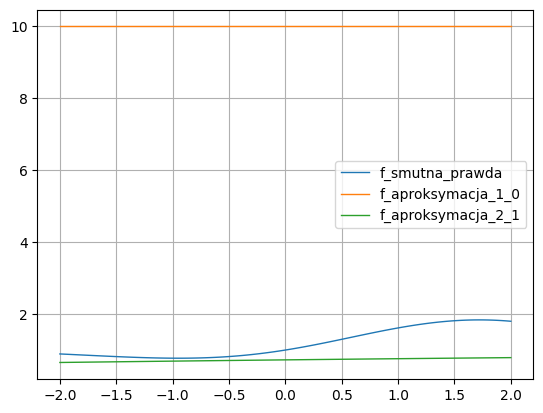

In [16]:
narysuj_wykres_funkcji(f_smutna_prawda, label='f_smutna_prawda', x_min=-2, x_max=2)
narysuj_wykres_funkcji(f_aproksymacja_1_0, label='f_aproksymacja_1_0', x_min=-2, x_max=2)
narysuj_wykres_funkcji(f_aproksymacja_2_1, label='f_aproksymacja_2_1', x_min=-2, x_max=2)

In [17]:
smutne_x, smutne_y = stworz_zbior_danych(f=f_smutna_prawda, n=100, x_min=-0.1, x_max=0.1, szum=None)

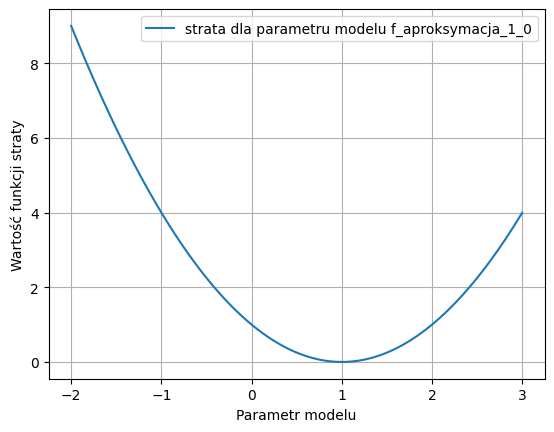

In [18]:
zwizualizuj_fstraty_dla_jednego_parametru(f_straty_1, smutne_x, smutne_y, f_aproksymacja_1_0, theta_min=-2, theta_max=3, label='strata dla parametru modelu f_aproksymacja_1_0')

Mimo, że funkcja $f_{prawda}$ uległą znacznemu skomplikowaniu i nasz model z jednym parametrem nie może skuteczniej jej aproksymować to ogólny kształt funkcji jesta nadal taki samo (`TODO` ćwiczenie). (`TODO` - jaka po optymalizacji będzie wartość parametru dla zbioru danych w ogólnyum przypadku?)

Sprwdźmy teraz jak wyglądają funkcje straty dla modeli dwuparametrowych.

In [19]:
def zwizualizuj_fstraty_dla_dwoch_parametrow(f_straty: Callable, x: Tensor, y: Tensor, model: nn.Module, theta1_min: float, theta1_max: float, theta2_min: float, theta2_max: float, label: str) -> None:
    thety1 = torch.linspace(start=theta1_min, end=theta1_max, steps=100)
    thety2 = torch.linspace(start=theta2_min, end=theta2_max, steps=100)
    thety12 = torch.meshgrid(thety1, thety2)

    straty2d = torch.empty((100, 100))
    for i in range(100):
        for j in range(100):
            model.theta[0].data.fill_(thety12[0][i][j])
            model.theta[1].data.fill_(thety12[1][i][j])
            y_pred = model(x)
            straty2d[i, j] = f_straty(y_pred, y).detach()
    plt.contourf(thety1, thety2, straty2d, levels=100)
    
    # Add contour lines with labels
    cs = plt.contour(thety1, thety2, straty2d, levels=20, colors='black')
    plt.clabel(cs, inline=True, fontsize=8)
    
    plt.xlabel('Parametr modelu 1')
    plt.ylabel('Parametr modelu 2')
    plt.colorbar()
    plt.grid()

d:\ml\.venv\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


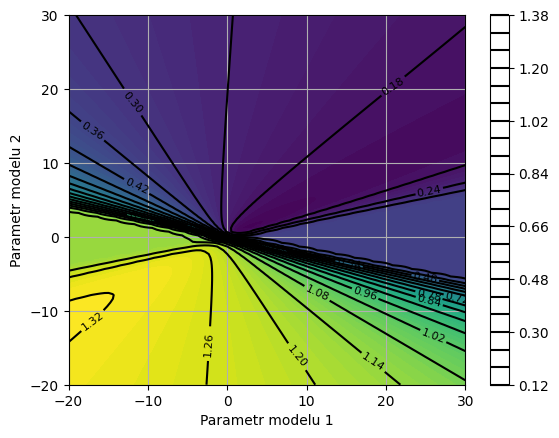

In [20]:
zwizualizuj_fstraty_dla_dwoch_parametrow(f_straty_1, x, y, f_aproksymacja_2_0, theta1_min=-20, theta1_max=30, theta2_min=-20, theta2_max=30, label='strata dla parametrów modelu f_aproksymacja_2_0')

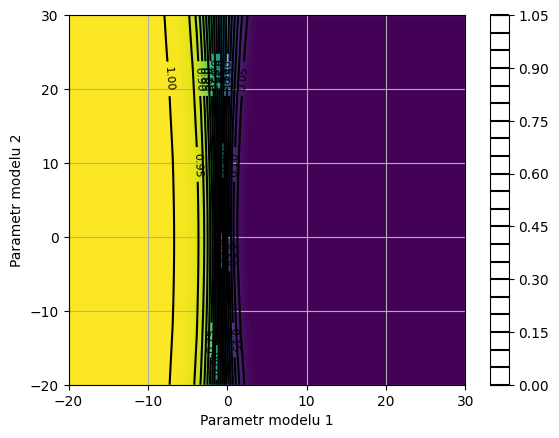

In [21]:
zwizualizuj_fstraty_dla_dwoch_parametrow(f_straty_1, smutne_x, smutne_y, f_aproksymacja_2_0, theta1_min=-20, theta1_max=30, theta2_min=-20, theta2_max=30, label='strata dla parametrów modelu f_aproksymacja_2_0')

In [22]:
from mpl_toolkits.mplot3d import Axes3D

def zwizualizuj_fstraty_dla_dwoch_parametrow3d(f_straty: Callable, x: Tensor, y: Tensor, model: nn.Module, theta1_min: float, theta1_max: float, theta2_min: float, theta2_max: float, label: str) -> None:
    thety1 = torch.linspace(start=theta1_min, end=theta1_max, steps=100)
    thety2 = torch.linspace(start=theta2_min, end=theta2_max, steps=100)
    thety12 = torch.meshgrid(thety1, thety2)

    straty2d = torch.empty((100, 100))
    for i in range(100):
        for j in range(100):
            model.theta[0].data.fill_(thety12[0][i][j])
            model.theta[1].data.fill_(thety12[1][i][j])
            y_pred = model(x)
            straty2d[i, j] = f_straty(y_pred, y).detach()

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(thety12[0].numpy(), thety12[1].numpy(), straty2d.numpy(), cmap='viridis')
    
    ax.set_xlabel('Parametr modelu 1')
    ax.set_ylabel('Parametr modelu 2')
    ax.set_zlabel('Strata')
    plt.show()

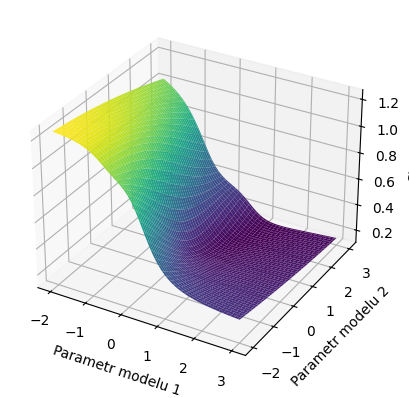

In [23]:
zwizualizuj_fstraty_dla_dwoch_parametrow3d(f_straty_1, x, y, f_aproksymacja_2_0, theta1_min=-2, theta1_max=3, theta2_min=-2, theta2_max=3, label='strata dla parametrów modelu f_aproksymacja_2_0')

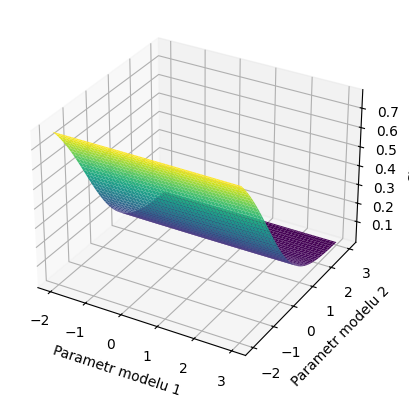

In [24]:
zwizualizuj_fstraty_dla_dwoch_parametrow3d(f_straty_1, smutne_x, smutne_y, f_aproksymacja_2_0, theta1_min=-2, theta1_max=3, theta2_min=-2, theta2_max=3, label='strata dla parametrów modelu f_aproksymacja_2_0')

TODO: dodać aktywacje i wpływ na kształt lossa
dodać wiel neuronów i plot dla dwoch

I tak zajęcia po zajęciach będziemy wizualizować funkcję straty dla modeli z coraz to większą liczbą parametrów aż zwizualizujemy funkcję straty dla czata. Będziemy używać do tego papieru milimetrowego. Prosze przygotować takowy na kolejne zajęcia. (<small>żart</small>)

TODO; kolejne zajęcia patrzenie jak się sieci dopasowują do danych dla jednego neuronu w warstwie i wielu w jednej ukrytej warstwie

### Dodajmy trochę losowości

żródła losowości ba nawet nasz zbiór danych jest próbką losową

wykres f straty
- rozne lossy
- losowosc dodana do relacji f_prawda - niedeterminizmi, teraz f_prawda modeluje E[y|x] (poznamy pozniej)

overexpressive for the problem, underexpressive

dodawanie wielu warstw pojedynczego neuronu, dodawanie wielu neuronow w jednej warstwie i wizualizacja jak przyblizana jest funkcja (robienei tego w linear casie i potem z aktywacjami)

In [25]:
dac wiele parametrow do jednego modelu i zwizualizowac tylko 2 parametery, aby byla skomplikowana funkcja straty i fajny ksztalt

SyntaxError: invalid syntax (456810029.py, line 1)

# convolution - finding fiter used to transform many images
write the linear system of equations to find the filter and make a model to triain the filter

wizualizacja grafu obliczeń i robienie własnych grafów obliczeń

wizualizacja lossa jako funkcji wybranych dwóch parametrów lub aktywacji w sieci, aby pokazać jak się zmienia perspektywa -> gradienty dla danej warstwy

zrobienie histogramów dla cosine similarity wzorców, aby pokazać jak są na wejściowym obrazku wykrywane wzorce. zrobić wizualizacje tych feature map wszystkich po kolei w sieci. zrobić jak najmniej ich. niech to będzie na cifarze10 bez kolorow zrobione

bardziej skomplikowana funkcja i jak wyglądają zfitowane funkcje z różnymi actiavtion funkcjami i liczbą warstw (tutaj jeden input i jeden output)

dla sieci splotowych szukanie niewidocznych obrazków (takich, które są prostopadłe do filtrów)

MC do przybliżonego całkowania sieci neuronowej

collapse of AE ehen passiign the same data to the encoder and decoder repetedly

# Ćwiczenia

## Praktyka

Zaimplementuj funkcję strat w pytorchu i sprawdź czy przechodzą testy

Sprawdź typy atrybutów i klas modeli za pomocą `type()`. Wywołaj .parameters() an obiekcie klasy nn.Module